There are two main benefits to using transfer learning:

Can leverage an existing neural network architecture proven to work on problems similar to our own.
Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

In [1]:
!nvidia-smi

Tue Nov 14 16:12:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Downloading and becoming one with data



In [2]:
import zipfile
#Get data(10% of the 10 food classes dataset)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-11-14 16:12:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.207, 142.250.1.207, 142.251.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   100MB/s    in 1.6s    

2023-11-14 16:12:43 (100 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent

So we can see we have only 10 percent of training data (75 images)

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
train_dir="10_food_classes_10_percent/train/"
test_dir="10_food_classes_10_percent/test/"
train_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)
print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##setting up callbacks(things to run whilst our model trains)
Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

Experiment tracking with TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.

Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.

Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.

In [5]:
#create tensorboard callback(functionized bcz we need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%d%m%Y-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback

#Creating model using tensorflow hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pre-trained models on:https://tfhub.dev/

After filtering out we found the following feature vector model:

1. https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

2. https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5

Now lets compare the following models

In [6]:
resnet_url="https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
efficient_url="https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [7]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
#Lets make a create model function to create a model from a URL
def create_model(model_url,num_classes=10):
  """
  Takes a url and creates a keras sequential model with it.

  Returns:an Uncompiled keras sequential model with mdoel_url as feature extractor layer and Dense output layer with num_classes output neurons.
  """
  #download the pretrained model and save it as a keras layer
  feature_extraction_layer=hub.KerasLayer(model_url,trainable=False,name="feature_extraction_layer",input_shape=IMAGE_SHAPE+(3,))

  #Create our own model
  model=tf.keras.Sequential([feature_extraction_layer,layers.Dense(num_classes,activation="softmax",name="Output_Layer")])

  return model


In [9]:
resnet_model=create_model(resnet_url,num_classes=train_data_10_percent.num_classes)

In [10]:
resnet_model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(),metrics=["accuracy"])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 Output_Layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [12]:
resnet_history=resnet_model.fit(train_data_10_percent,epochs=5,steps_per_epoch=len(train_data_10_percent),validation_data=test_data,
                                callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                          # save experiment logs here
                                          experiment_name="resnet50V2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50V2/14112023-161257
Epoch 1/5
24/24 [==============================] - 26s 606ms/step - loss: 2.0113 - accuracy: 0.3227 - val_loss: 1.2182 - val_accuracy: 0.6268
Epoch 2/5
24/24 [==============================] - 13s 544ms/step - loss: 0.9355 - accuracy: 0.7227 - val_loss: 0.8865 - val_accuracy: 0.7192
Epoch 3/5
24/24 [==============================] - 16s 668ms/step - loss: 0.6500 - accuracy: 0.8173 - val_loss: 0.7638 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 13s 543ms/step - loss: 0.5002 - accuracy: 0.8533 - val_loss: 0.7101 - val_accuracy: 0.7672
Epoch 5/5
24/24 [==============================] - 10s 446ms/step - loss: 0.3961 - accuracy: 0.8947 - val_loss: 0.6934 - val_accuracy: 0.7788


In [14]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

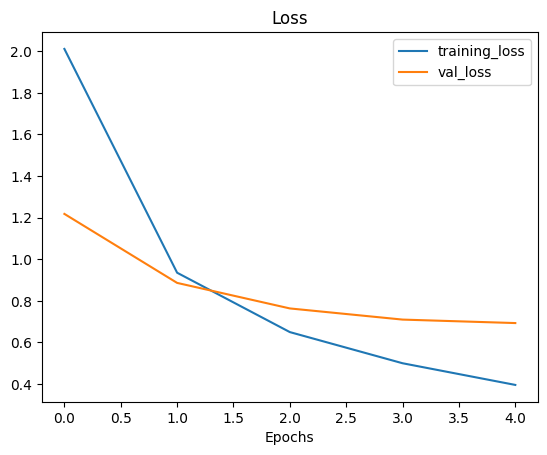

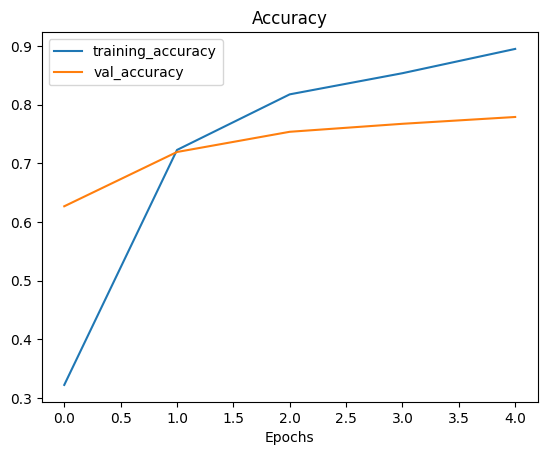

In [15]:
plot_loss_curves(resnet_history)

In [16]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 Output_Layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


You can see the power of TensorFlow Hub here. The feature extraction layer has 23,564,800 parameters which are prelearned patterns the model has already learned on the ImageNet dataset. Since we set trainable=False, these patterns remain frozen (non-trainable) during training.

This means during training the model updates the 20,490 parameters in the output layer to suit our dataset.

Okay, we've trained a ResNetV250 model, time to do the same with EfficientNetB0 model.

In [18]:
efficientnet_model = create_model(model_url=efficient_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving Tensorboard log files to: tensorflow_hub/efficientnetB0/14112023-162645
Epoch 1/5
24/24 [==============================] - 23s 533ms/step - loss: 1.8178 - accuracy: 0.4387 - val_loss: 1.2584 - val_accuracy: 0.7416
Epoch 2/5
24/24 [==============================] - 10s 446ms/step - loss: 1.0488 - accuracy: 0.7720 - val_loss: 0.8496 - val_accuracy: 0.8184
Epoch 3/5
24/24 [==============================] - 12s 536ms/step - loss: 0.7547 - accuracy: 0.8347 - val_loss: 0.6874 - val_accuracy: 0.8396
Epoch 4/5
24/24 [==============================] - 12s 498ms/step - loss: 0.6041 - accuracy: 0.8667 - val_loss: 0.6016 - val_accuracy: 0.8548
Epoch 5/5
24/24 [==============================] - 10s 439ms/step - loss: 0.5118 - accuracy: 0.8893 - val_loss: 0.5522 - val_accuracy: 0.8612


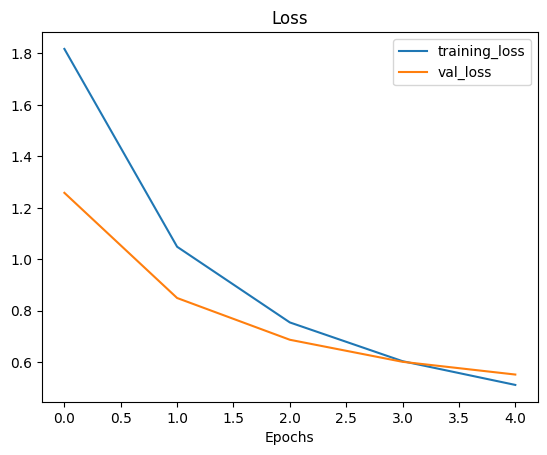

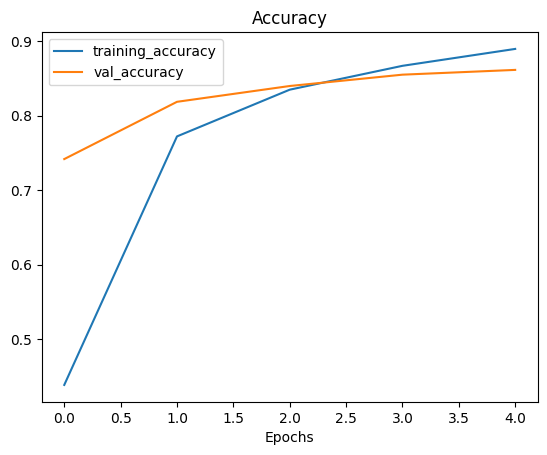

In [19]:
plot_loss_curves(efficientnet_history)


##Types of transfer learning

1-"As in"-using an existing model with no changes what so ever

2-"Feature Extraction"-using the prelearned patters of an existing modeland adjust the output layer for your own print_dtensor_variable_summary

3."fine-tuning"-use the prelearned patterns of an existing model and fine-tune many or al of the underlaying layers